In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import dct, idct
from PIL import Image
from io import BytesIO


cover_image_path = 'person_mask.jpg'
secret_image_path = 'me.png'

cover_image = cv2.imread(cover_image_path)
secret_image = cv2.imread(secret_image_path)

cover_image = cv2.imread(cover_image_path, cv2.IMREAD_GRAYSCALE)
secret_image = cv2.imread(secret_image_path, cv2.IMREAD_GRAYSCALE)


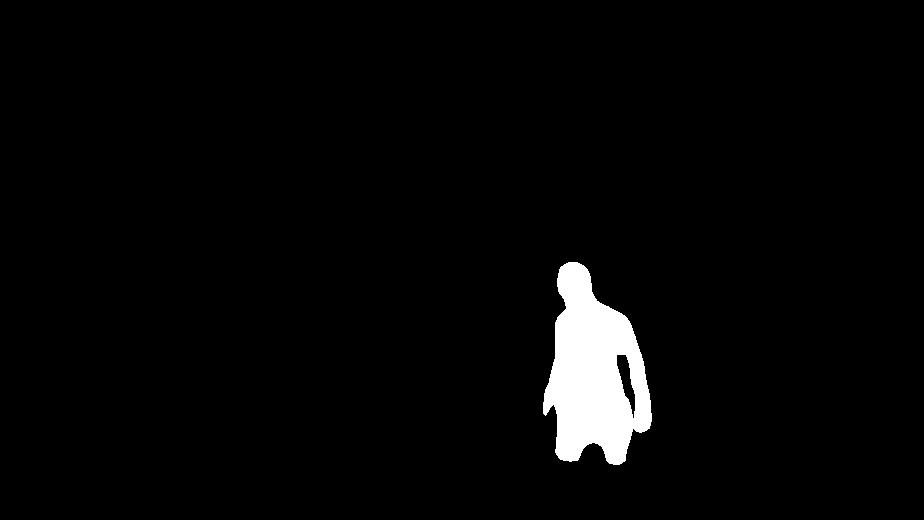

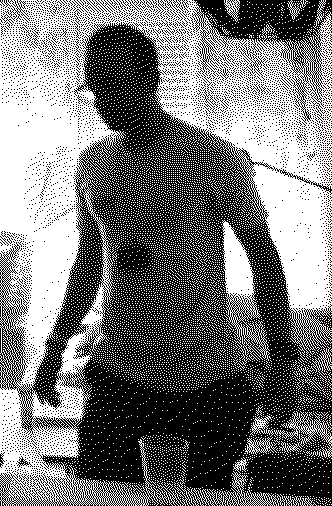

In [2]:
# Convert cover image to grayscale
cover = Image.open(cover_image_path)#.convert('L')
data_c = np.array(cover)
display(cover)

# Convert image to 1-bit pixel, black and white and resize to cover image
secret = Image.open(secret_image_path).convert('1')
secret_size = secret.size
display(secret)
secret = secret.resize(cover.size)


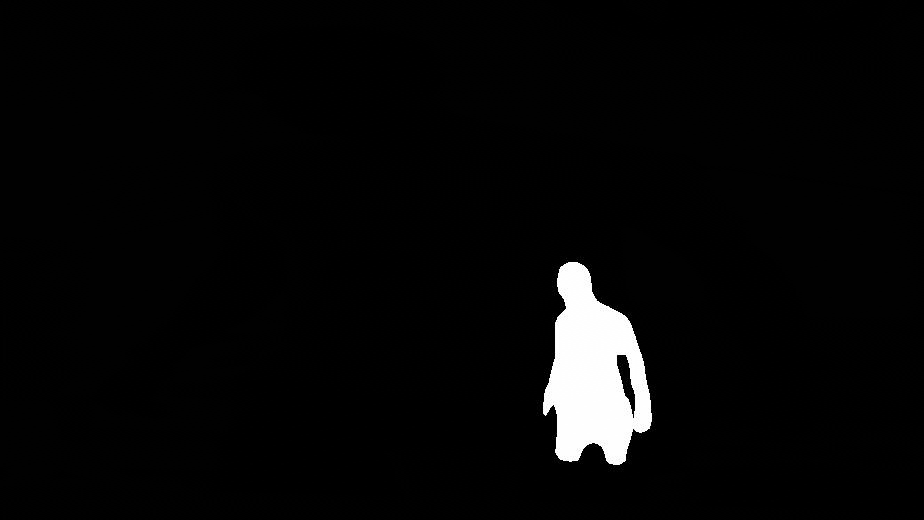

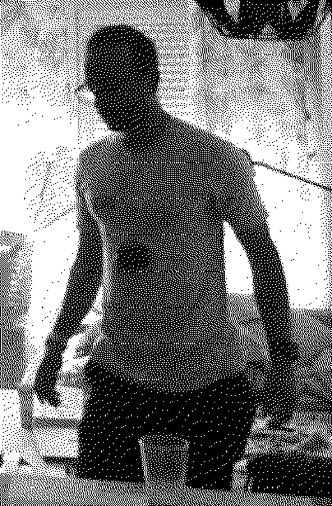

In [3]:
# Encode
data_s = np.array(secret, dtype=np.uint8)
res = data_c & ~1 | data_s
encoded_img = Image.fromarray(res).convert("L")
display(encoded_img)

# Decode
data_s = np.array(encoded_img)
data_s = data_s & 1
decoded_secret = Image.fromarray(data_s * np.uint(255))
decoded_secret = decoded_secret.resize(secret_size)
display(decoded_secret)

In [4]:
images = [secret, cover, encoded_img, decoded_secret]
image_names = ['secret', 'cover', 'encoded image', 'decoded secret']

for image, name in zip(images, image_names):
    img_file = BytesIO()
    image.save(img_file, format='PNG')
    image_file_size = img_file.tell()
    image_file_size_mb = image_file_size / (1024)
    print(f"{name} file size: {image_file_size_mb:.2f} KB")

secret file size: 30.32 KB
cover file size: 6.00 KB
encoded image file size: 39.08 KB
decoded secret file size: 120.01 KB


## DCT based steganography

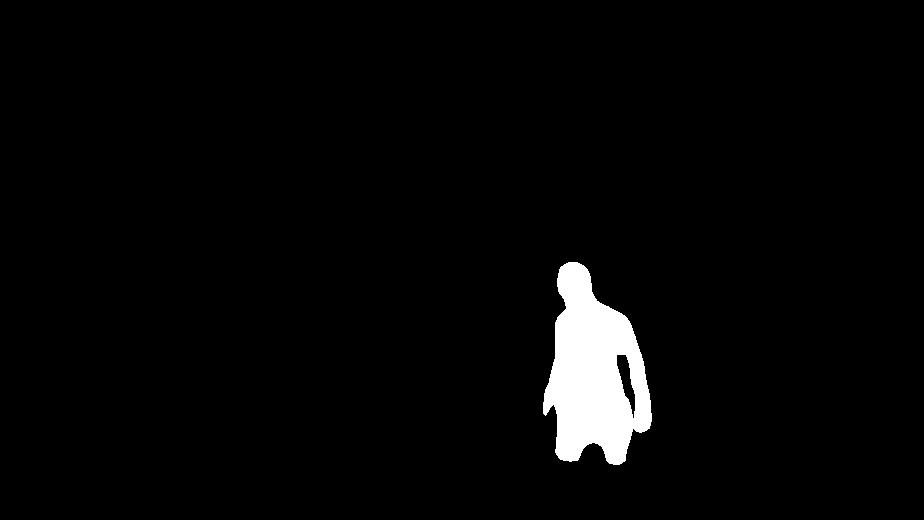

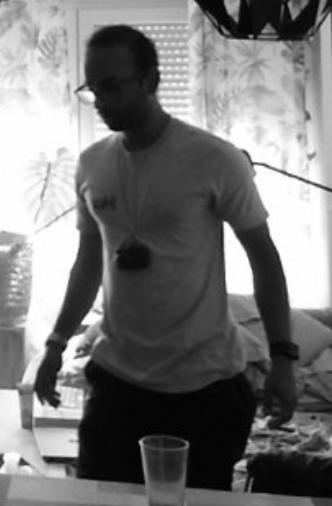

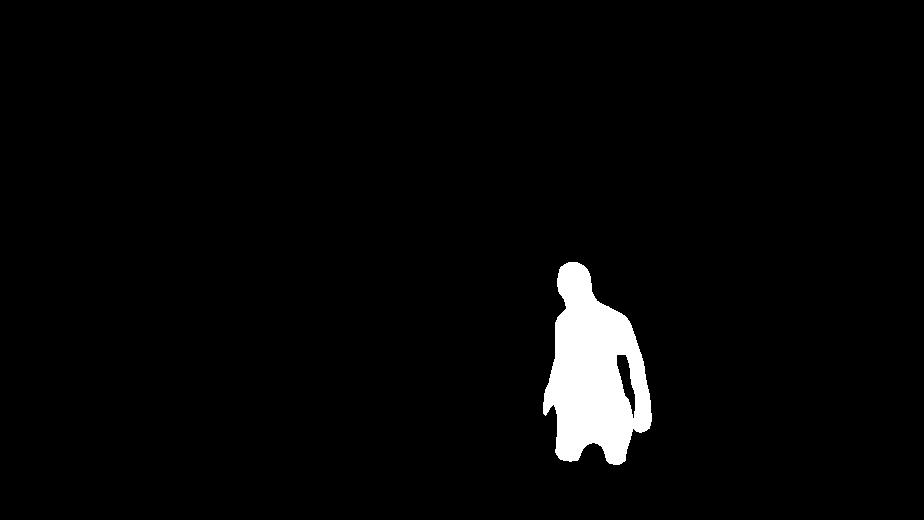

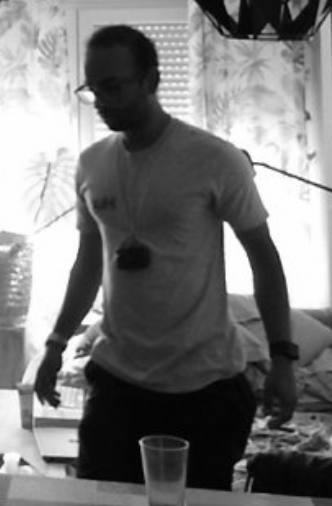

In [5]:
display(Image.fromarray(cover_image))
display(Image.fromarray(secret_image))
secret_image = secret_image / 255.0  # normalize secret image
scale_factor = 0.1  # change this to adjust the visibility of the secret image
secret_image = secret_image * scale_factor



assert cover_image.shape[0] >= secret_image.shape[0]
assert cover_image.shape[1] >= secret_image.shape[1]

cover_image_dct = np.zeros_like(cover_image, dtype=float)
block_size = 8
for i in range(0, cover_image.shape[0], block_size):
    for j in range(0, cover_image.shape[1], block_size):
        cover_image_dct[i:(i+block_size), j:(j+block_size)] = dct(dct(cover_image[i:(i+block_size), j:(j+block_size)].T, norm='ortho').T, norm='ortho')

cover_image_dct[block_size//2:block_size//2+secret_image.shape[0], block_size//2:block_size//2+secret_image.shape[1]] += secret_image


stego_image = np.zeros_like(cover_image_dct, dtype=float)
for i in range(0, cover_image_dct.shape[0], block_size):
    for j in range(0, cover_image_dct.shape[1], block_size):
        stego_image[i:(i+block_size), j:(j+block_size)] = idct(idct(cover_image_dct[i:(i+block_size), j:(j+block_size)].T, norm='ortho').T, norm='ortho')
stego_image = np.clip(stego_image, 0, 255)  # Ensure values are within 0-255
stego_image = stego_image.astype(np.uint8)  # Convert to 8-bit unsigned integer


display(Image.fromarray(stego_image))
decoded_secret = cover_image_dct[block_size//2:block_size//2+secret_image.shape[0], block_size//2:block_size//2+secret_image.shape[1]]
decoded_secret = decoded_secret / scale_factor  # scale back up
decoded_secret = np.clip(decoded_secret, 0, 1)  # ensure values are within 0-1
decoded_secret = (decoded_secret * 255).astype(np.uint8)  # convert back to 8-bit unsigned integer

display(Image.fromarray(decoded_secret))


In [6]:
images = [secret_image, cover_image, stego_image, decoded_secret]
images = [Image.fromarray(np.uint8(img)) for img in images]
image_names = ['secret', 'cover', 'encoded image', 'decoded secret']

for image, name in zip(images, image_names):
    img_file = BytesIO()
    image.save(img_file, format='PNG')
    image_file_size = img_file.tell()
    image_file_size_mb = image_file_size / (1024)
    print(f"{name} file size: {image_file_size_mb:.2f} KB")

secret file size: 0.24 KB
cover file size: 6.00 KB
encoded image file size: 6.01 KB
decoded secret file size: 68.97 KB
